# Semi-Supervised Classification with Graph Convolution Networks

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import igraph as ig
import scipy.linalg
tf.set_random_seed(777)  # reproducibility

In [2]:
def xavier_initializer(n_inputs, n_outputs, uniform = True):
    if uniform:
        init_range = tf.sqrt(6.0/ (n_inputs + n_outputs))
        return tf.random_uniform_initializer(-init_range, init_range)

    else:
        stddev = tf.sqrt(3.0 / (n_inputs + n_outputs))
        return tf.truncated_normal_initializer(stddev=stddev)

In [3]:
class GCNModel:
    def __init__(self, sess, adjacency_matrix, output_list, hidden_dims=[4,4,2],signal='Identity', activiation_function=tf.nn.tanh, learning_rate=0.1):
        if signal == 'Identity':
            self.X = np.identity(adjacency_matrix.shape[0], dtype=np.float32)
        else:
            self.X = signal
        
        self.Y = tf.one_hot(list(range(len(output_list))), len(output_list))
        self.sess = sess
        
        # make graph convolution filter
        A_hat = adjacency_matrix + np.identity(adjacency_matrix.shape[0])
        D_hat = np.diag([np.sum(row) for row in A_hat])
        D_hat_half = scipy.linalg.fractional_matrix_power(D_hat, -1/2)
        self.graph_convolution_filter = np.matmul(np.matmul(D_hat_half,adjacency_matrix), D_hat_half).astype('float32')
        #make graph convlution network
        current_dim = adjacency_matrix.shape[0]
        current_layer = self.X
        for i, h_dim in enumerate(hidden_dims):
            with tf.variable_scope('layer{}'.format(i)):
                W = tf.get_variable(shape=[current_dim,h_dim], name='weight', dtype=tf.float32, initializer=xavier_initializer(current_dim, h_dim))
                current_layer = activiation_function(tf.matmul(tf.matmul(self.graph_convolution_filter, current_layer), W))
                current_dim = h_dim
        self.layer_for_visualization = current_layer
        with tf.variable_scope('final_area'):
            W = tf.get_variable(shape=[current_dim, len(output_list)], name='weight', dtype=tf.float32, initializer=xavier_initializer(current_dim, len(output_list)))
            b = tf.Variable(tf.zeros([len(output_list)]), dtype=tf.float32, name='bias')
            current_layer = tf.matmul(current_layer,W) + b
        
        logits = tf.stack([current_layer[index] for index in output_list])
        self.loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=self.Y)
        self.loss = tf.reduce_mean(self.loss, name='loss')
        
        softmax = tf.nn.softmax(current_layer, name = 'softmax')
        self.assigned = tf.argmax(softmax, 1)
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)
        sess.run(tf.global_variables_initializer())
    
    def train(self):
        return self.sess.run([self.loss, self.optimizer])
    
    def assigned_result(self):
        return self.sess.run(self.layer_for_visualization)
    
    def calculate_accuracy_compared_to_known_optimal(self, optimal_value):
        accuracy = tf.reduce_mean(tf.cast(tf.equal(self.assigned, optimal_value), tf.float32))
        return self.sess.run(accuracy)


In [4]:
karate_network = ig.read('karate.gml')
communities = karate_network.community_optimal_modularity()

In [5]:
print('Number_of_optimal_communities: ' + str(len(communities)))
color_candidiate = ['red','blue','green','yellow']
color_list = [" "] * len(karate_network.vs)
community_list = [0] * len(karate_network.vs)

Number_of_optimal_communities: 4


## Known Optimal Community with modularity optimization

In [6]:
for i, community in enumerate(communities):
    for node in community:
        color_list[node] =  color_candidiate[i]
        community_list[node] = i
karate_network.vs['color'] = color_list
#ig.plot(karate_network, layout=karate_network.layout('fr'))

In [7]:
adjacency_matrix = np.array(karate_network.get_adjacency().data, dtype=np.float32)
import random
selected_node_list = [random.choice(community) for community in communities]

In [8]:
selected_node_list

[17, 6, 26, 23]

In [9]:
sess= tf.Session()
model = GCNModel(sess, adjacency_matrix, selected_node_list)

In [10]:
model.calculate_accuracy_compared_to_known_optimal(community_list)

0.11764706

## Node Embedding with Random Weights

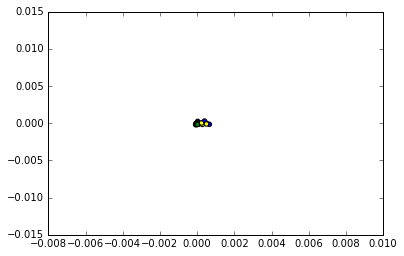

In [11]:
initial_result = model.assigned_result()
x_points = [x[0] for x in initial_result]
y_points = [x[1] for x in initial_result]
plt.scatter(x_points, y_points, c=color_list)
plt.show()

## Training

In [12]:
two_dim_result_list = []
accuracy_list = []
step_list = []
for i in range(10000):
    l, _ = model.train()
    if i==0 or i % 1000 == 0:
        print(i, l)
        step_list.append(i)
        two_dim_result_list.append(model.assigned_result())
        accuracy_list.append(model.calculate_accuracy_compared_to_known_optimal(community_list))

(0, 1.3862973)
(1000, 6.4996653e-05)
(2000, 1.5914304e-05)
(3000, 7.003518e-06)
(4000, 3.6358758e-06)
(5000, 2.0265556e-06)
(6000, 1.1324875e-06)
(7000, 6.5565087e-07)
(8000, 4.1723243e-07)
(9000, 2.6822087e-07)


## Result

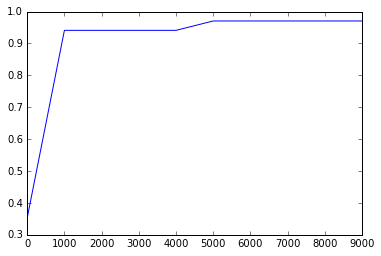

Initial Accuracy:  0.352941
Final Accuracy:  0.970588


In [16]:
plt.plot(step_list, accuracy_list)
plt.show()

print "Initial Accuracy: ", accuracy_list[0]
print "Final Accuracy: ", accuracy_list[-1]

step: 0


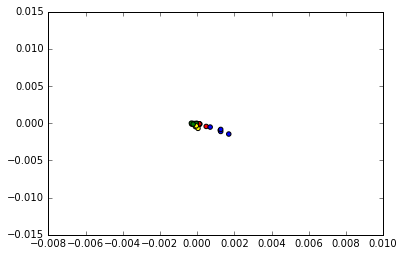

step: 1000


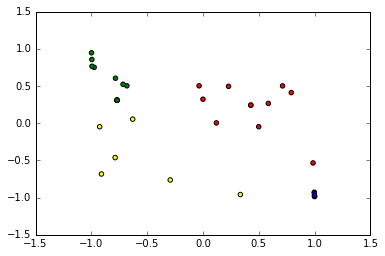

step: 2000


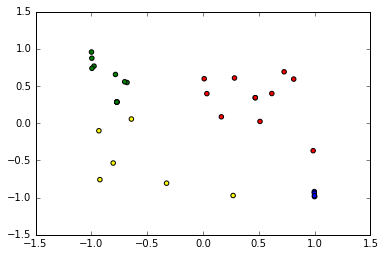

step: 3000


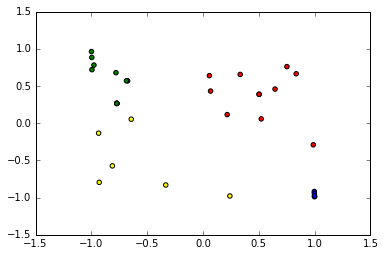

step: 4000


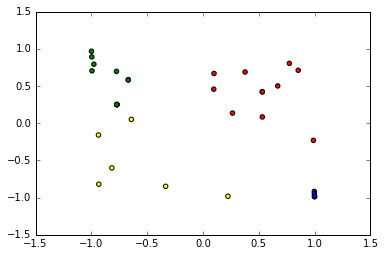

step: 5000


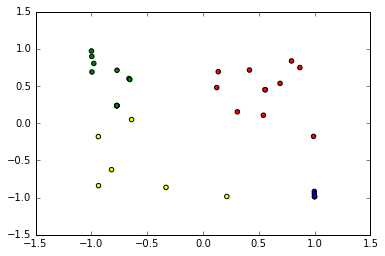

step: 6000


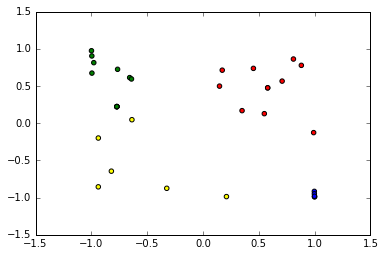

step: 7000


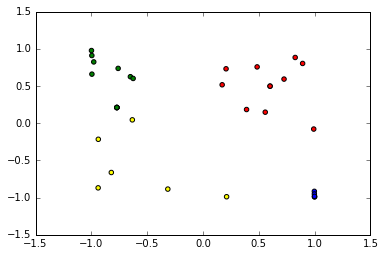

step: 8000


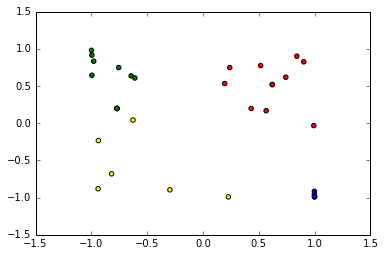

step: 9000


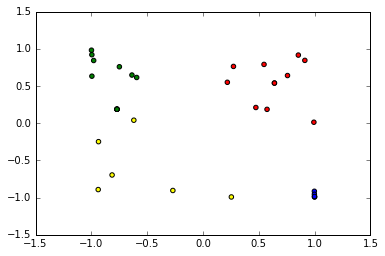

'\nfor i, result in enumerate(two_dim_result_list):\n    if i % 2000 == 0:\n        x_points = [x[0] for x in result]\n        y_points = [x[1] for x in result]\n        plt.scatter(x_points, y_points, c=color_list)\n        print("step: " + str(step_list[i]))\n        plt.show()\n'

In [17]:
total_iteration = len(two_dim_result_list)
visualization_index = range(0, total_iteration, total_iteration/10 )

for i in visualization_index:
    x_points = [x[0] for x in two_dim_result_list[i]]
    y_points = [x[1] for x in two_dim_result_list[i]]
    plt.scatter(x_points, y_points, c=color_list)
    print("step: " + str(step_list[i]))
    plt.show()
'''
for i, result in enumerate(two_dim_result_list):
    if i % 2000 == 0:
        x_points = [x[0] for x in result]
        y_points = [x[1] for x in result]
        plt.scatter(x_points, y_points, c=color_list)
        print("step: " + str(step_list[i]))
        plt.show()
'''